In [1]:
from time import sleep
import cv2
from sklearn.cluster import KMeans
import numpy as np
from skimage import io
import spotipy
import imutils
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
#use k-means in lab colorspace to determine dominant colors, returns colors in LAB color space
def dominantColorsLAB(img,clusters):
    
    #convert to lab from bgr
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
            
    #reshaping to a list of pixels
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    
    
    #using k-means to cluster pixels, set seed so that colors are deterministic
    kmeans = KMeans(n_clusters=clusters,max_iter=300,tol=1e-3,random_state=42)
    kmeans.fit(img)
    
    colors = kmeans.cluster_centers_

    return colors.astype(int)

In [3]:
#get colors for light [0],[1] would be primary colors, [2] a trim color, and [3] a background color
def getLights(img):
    #check for desired colors on various incrementing cluster sizes
    for clusters in range(4,10):

        #run the k-means in LAB color space
        colors = dominantColorsLAB(img, clusters).tolist()

        #try to find 3 bright colors, [0] is the L in LAB
        brightColors = list(filter(lambda x: x[0] > 110, colors))
        if(len(brightColors) < 3):
            continue

        #only take the top 3 bright colors as returned from the k-means
        brightColors = brightColors[:3]

        #set bg color to be the most dominant color cluster remaining
        bgColor =[0,0,0]
        for color in colors:
            if(color not in brightColors):
                bgColor = color
                break
        brightColors.append(bgColor)

        print("# clusters: {}".format(clusters))

        #convert to rgb before returning
        return cv2.cvtColor(np.uint8([brightColors]), cv2.COLOR_LAB2RGB)[0]
    
    #fallthrough
    print("Failed to find desired colors")

    #just get the 4 most dominant colors and sort them by brightness decending
    #TODO: cache this the first time
    failColors = dominantColorsLAB(img, 4) 
    failColors = sorted(failColors,key=lambda x:x[0],reverse=True)
    
    #convert to rgb before returning
    return cv2.cvtColor(np.uint8([failColors]), cv2.COLOR_LAB2RGB)[0]

        
            

In [4]:
#get colors for palette [0-7] would be primary colors and [8] a background color
def getPalette(img):
    #check for desired colors on various incrementing cluster sizes
    for clusters in range(9,20):

        #run the k-means in LAB color space
        colors = dominantColorsLAB(img, clusters).tolist()

        colorsRGB = cv2.cvtColor(np.uint8([colors]), cv2.COLOR_LAB2RGB)[0]

        colorsHSV = cv2.cvtColor(np.uint8([colorsRGB]), cv2.COLOR_RGB2HSV)[0]

        #try to find 7 bright colors, [2] is the V in HSV
        brightColors = list(filter(lambda x: x[2] > 140, colorsHSV))
        if(len(brightColors) < 8):
            continue

        #only take the top 8 bright colors as returned from the k-means
        brightColors = brightColors[:8]

        #set bg color to be the most dominant color cluster remaining
        bgColor = np.uint8([0,0,0])
        for color in colorsHSV:
            if (not np.isin(color, brightColors).all()) and color[2] < 80:
                bgColor = color

                #function to darken bg color
                bgColor[2] = int(19 + 0.000339006 * (-37.8 + color[2])**3)
                break

        if((bgColor == [0,0,0]).all()):
            continue
        brightColors.append(bgColor)

        print("# clusters: {}".format(clusters))

        #convert to rgb before returning
        return cv2.cvtColor(np.uint8([brightColors]), cv2.COLOR_HSV2RGB)[0]
    
    #fallthrough
    print("Failed to find desired colors")

    #just get the 4 most dominant colors and sort them by brightness decending
    #TODO: cache this the first time
    failColors = dominantColorsLAB(img, 9) 
    failColorsRGB = cv2.cvtColor(np.uint8([failColors]), cv2.COLOR_LAB2RGB)[0]
    failColorsHSV = cv2.cvtColor(np.uint8([failColorsRGB]), cv2.COLOR_RGB2HSV)[0]
    failColorsHSV = sorted(failColorsHSV,key=lambda x:x[2],reverse=True)
    dark = int(19 + 0.000339006 * (-37.8 + failColorsHSV[8][2])**3)
    if(dark > 50):
        dark = 50
    failColorsHSV[8][2] = dark
    #convert to rgb before returning
    
    return cv2.cvtColor(np.uint8([failColorsHSV]), cv2.COLOR_HSV2RGB)[0]

In [5]:
#get spotify info from text file
secretFile = open('secret.txt')

#set enviroment variables for auth
os.environ['SPOTIPY_CLIENT_ID'] = secretFile.readline().strip()
os.environ['SPOTIPY_CLIENT_SECRET'] = secretFile.readline().strip()
os.environ['SPOTIPY_REDIRECT_URI'] = secretFile.readline().strip()

userID = secretFile.readline().strip()
secretFile.close()

#spotipy OAuth should automatically handle token refresh
spotify = spotipy.Spotify(auth_manager=spotipy.SpotifyOAuth(scope='user-read-currently-playing',cache_path='.cache-'+userID))

lastURL = ""

In [6]:
def color2hex(color):

    retStr = ""
    for ele in color:
        hexVal = hex(ele)[2:]
        if (len(hexVal) == 1):
            hexVal = '0' + hexVal
        retStr += hexVal

    return retStr


In [7]:
def writeColors(filepath, colors):

    file = open(filepath,"w")
    for color in colors:
        file.write("#" + color2hex(color) + "\n")


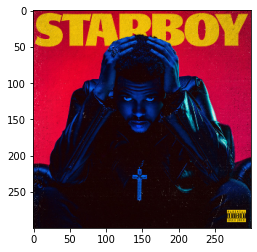

# clusters: 7


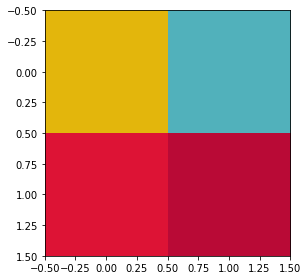

# clusters: 14


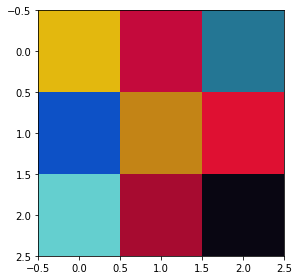

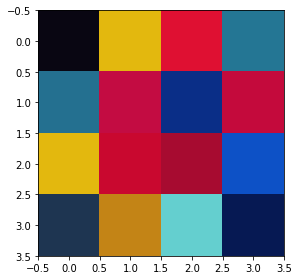

In [8]:
while(True):

    #token should refresh automatically
    track = spotify.current_user_playing_track()

    #handle bad track objects and rate limiting
    try:
        #sometimes this pulls different art than is displayed in the player?
        #might be the case when the artist updates their album art
        #example https://open.spotify.com/track/2EiYIBGH83p6ORjs14Rdgy?si=b8504fd795b046d7
        #this pulls the art from the greatest hits album, but the spotify player displays the remaster art
        #I wonder if the song in this greastest hits album is a symlink, it's not even conistent in the spotify player, the song thumbnail is the greatest hits album
        imageURL = track['item']['album']['images'][0]['url']   
    except TypeError or ConnectionError:
        imageURL = lastURL
        sleep(1)
    #handle songs with no art
    except IndexError:
        imageURL = lastURL
        sleep(1)

    
    #if the art has changed
    if(lastURL != imageURL):
        lastURL = imageURL

        try:
            img = imutils.url_to_image(lastURL)
        except ConnectionError:
            sleep(1)
            continue

        #decimation, optimization for speed
        img  = cv2.resize(img,(300,300))
        
        #convert opencv BGR image to RGB for notebook
        imgRBG = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #display album in notebook
        plt.imshow(imgRBG)
        plt.show()
        
        #get color palette
        colorsLAB = getLights(img)
        paletteLAB = np.array(colorsLAB, dtype=np.uint8)

        
        #display a color swatch
        display = np.array([[0,1],[2,3]], dtype=np.uint8)
        io.imshow(paletteLAB[display])
        io.show()


        #for vscode addon
        large = dominantColorsLAB(img,16)
        large = cv2.cvtColor(np.uint8([large]), cv2.COLOR_LAB2RGB)[0]
        

        pal = getPalette(img)

        displayLarge = np.array([[ 0,  1,  2,  3],
                                 [ 4,  5,  6,  7],
                                 [ 8,  9, 10, 11],
                                 [12, 13, 14, 15]], dtype=np.uint8)
        
        displayPal = np.array([[0, 1, 2],
                               [3, 4, 5],
                               [6, 7, 8]], dtype=np.uint8)

        io.imshow(pal[displayPal])
        io.show()

        #bg
        large[0] = pal[8]
        #fill in meaningful part of palette
        large[1] = pal[0]
        large[2] = pal[5]
        large[3] = pal[2]
        large[11] = pal[3]
        large[7] = pal[1]
        large[14] = pal[6]
        large[10] = pal[7]

        #trim color
        large[8] = pal[0]
        large[13] = pal[4]

        writeColors("C:\\Users\\Fabio\\.cache\\wal\\colors", large)

        io.imshow(large[displayLarge])
        io.show()
        
        clear_output(wait=True)

    #spotify api is fine with 3600 req/hour
    sleep(1)